In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
data_df = pd.read_csv('../../../_data/Tavares2017.csv')
data_df['rt'] /= 1000

data_df.rename(columns={'subject': 'sbj'}, inplace=True)

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 2 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df.reset_index(drop=True, inplace=True)

data_df['Right Value - Left Value'] = data_df['item_value_1'] - data_df['item_value_0']

data_df['gaze diff'] = data_df['gaze_1'] - data_df['gaze_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - L)'] = mms.fit_transform(data_df[['gaze diff']])


min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'choice', 'sbj']])
X_train = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1']])

obs_test = np.asarray(data_df[['rt', 'choice', 'sbj']])
X_test = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1']])

print(X_train.shape, X_test.shape)

(30464, 4) (30464, 4)


In [5]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2 + 0.1**14), axis=-1)

In [6]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 87        
                                                                 
Total params: 380 (1.48 KB)
Trainable params: 380 (1.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=4000)

Epoch 1/4000
1/1 [==============================] - 1s 1s/step - loss: 163516.3125
Epoch 2/4000
1/1 [==============================] - 0s 11ms/step - loss: 162787.7188
Epoch 3/4000
1/1 [==============================] - 0s 11ms/step - loss: 162266.9844
Epoch 4/4000
1/1 [==============================] - 0s 11ms/step - loss: 161834.5469
Epoch 5/4000
1/1 [==============================] - 0s 11ms/step - loss: 161453.2344
Epoch 6/4000
1/1 [==============================] - 0s 12ms/step - loss: 161105.9219
Epoch 7/4000
1/1 [==============================] - 0s 11ms/step - loss: 160783.0781
Epoch 8/4000
1/1 [==============================] - 0s 10ms/step - loss: 160478.7656
Epoch 9/4000
1/1 [==============================] - 0s 11ms/step - loss: 160189.0156
Epoch 10/4000
1/1 [==============================] - 0s 11ms/step - loss: 159910.9062
Epoch 11/4000
1/1 [==============================] - 0s 11ms/step - loss: 159642.3438
Epoch 12/4000
1/1 [==============================] - 0s 11ms/step

1/1 [==============================] - 0s 14ms/step - loss: 143702.4688
Epoch 97/4000
1/1 [==============================] - 0s 13ms/step - loss: 143556.3906
Epoch 98/4000
1/1 [==============================] - 0s 13ms/step - loss: 143411.1250
Epoch 99/4000
1/1 [==============================] - 0s 12ms/step - loss: 143266.6562
Epoch 100/4000
1/1 [==============================] - 0s 11ms/step - loss: 143123.0312
Epoch 101/4000
1/1 [==============================] - 0s 13ms/step - loss: 142980.1719
Epoch 102/4000
1/1 [==============================] - 0s 11ms/step - loss: 142838.1406
Epoch 103/4000
1/1 [==============================] - 0s 13ms/step - loss: 142696.8906
Epoch 104/4000
1/1 [==============================] - 0s 13ms/step - loss: 142556.4375
Epoch 105/4000
1/1 [==============================] - 0s 12ms/step - loss: 142416.7500
Epoch 106/4000
1/1 [==============================] - 0s 12ms/step - loss: 142277.8438
Epoch 107/4000
1/1 [==============================] - 0s 13ms

1/1 [==============================] - 0s 15ms/step - loss: 132832.0938
Epoch 191/4000
1/1 [==============================] - 0s 15ms/step - loss: 132740.3750
Epoch 192/4000
1/1 [==============================] - 0s 14ms/step - loss: 132649.0156
Epoch 193/4000
1/1 [==============================] - 0s 14ms/step - loss: 132558.0156
Epoch 194/4000
1/1 [==============================] - 0s 14ms/step - loss: 132467.4062
Epoch 195/4000
1/1 [==============================] - 0s 13ms/step - loss: 132377.1250
Epoch 196/4000
1/1 [==============================] - 0s 20ms/step - loss: 132287.2188
Epoch 197/4000
1/1 [==============================] - 0s 14ms/step - loss: 132197.6875
Epoch 198/4000
1/1 [==============================] - 0s 13ms/step - loss: 132108.4688
Epoch 199/4000
1/1 [==============================] - 0s 14ms/step - loss: 132019.6250
Epoch 200/4000
1/1 [==============================] - 0s 13ms/step - loss: 131931.1094
Epoch 201/4000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 14ms/step - loss: 125090.9141
Epoch 285/4000
1/1 [==============================] - 0s 13ms/step - loss: 125007.8125
Epoch 286/4000
1/1 [==============================] - 0s 13ms/step - loss: 124924.5312
Epoch 287/4000
1/1 [==============================] - 0s 13ms/step - loss: 124841.0625
Epoch 288/4000
1/1 [==============================] - 0s 12ms/step - loss: 124757.4062
Epoch 289/4000
1/1 [==============================] - 0s 12ms/step - loss: 124673.5781
Epoch 290/4000
1/1 [==============================] - 0s 14ms/step - loss: 124589.5625
Epoch 291/4000
1/1 [==============================] - 0s 14ms/step - loss: 124505.3828
Epoch 292/4000
1/1 [==============================] - 0s 14ms/step - loss: 124421.0156
Epoch 293/4000
1/1 [==============================] - 0s 12ms/step - loss: 124336.4375
Epoch 294/4000
1/1 [==============================] - 0s 13ms/step - loss: 124251.7109
Epoch 295/4000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 15ms/step - loss: 116190.1875
Epoch 379/4000
1/1 [==============================] - 0s 16ms/step - loss: 116088.1250
Epoch 380/4000
1/1 [==============================] - 0s 15ms/step - loss: 115986.5078
Epoch 381/4000
1/1 [==============================] - 0s 14ms/step - loss: 115885.2109
Epoch 382/4000
1/1 [==============================] - 0s 14ms/step - loss: 115784.3438
Epoch 383/4000
1/1 [==============================] - 0s 14ms/step - loss: 115683.8281
Epoch 384/4000
1/1 [==============================] - 0s 14ms/step - loss: 115583.7344
Epoch 385/4000
1/1 [==============================] - 0s 13ms/step - loss: 115483.9922
Epoch 386/4000
1/1 [==============================] - 0s 15ms/step - loss: 115384.6719
Epoch 387/4000
1/1 [==============================] - 0s 14ms/step - loss: 115285.6953
Epoch 388/4000
1/1 [==============================] - 0s 14ms/step - loss: 115187.1406
Epoch 389/4000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 14ms/step - loss: 107571.8750
Epoch 473/4000
1/1 [==============================] - 0s 15ms/step - loss: 107488.5156
Epoch 474/4000
1/1 [==============================] - 0s 14ms/step - loss: 107405.2500
Epoch 475/4000
1/1 [==============================] - 0s 16ms/step - loss: 107322.1328
Epoch 476/4000
1/1 [==============================] - 0s 14ms/step - loss: 107239.1250
Epoch 477/4000
1/1 [==============================] - 0s 14ms/step - loss: 107156.2656
Epoch 478/4000
1/1 [==============================] - 0s 15ms/step - loss: 107073.5469
Epoch 479/4000
1/1 [==============================] - 0s 14ms/step - loss: 106990.9688
Epoch 480/4000
1/1 [==============================] - 0s 14ms/step - loss: 106908.5469
Epoch 481/4000
1/1 [==============================] - 0s 14ms/step - loss: 106826.2734
Epoch 482/4000
1/1 [==============================] - 0s 15ms/step - loss: 106744.1562
Epoch 483/4000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 19ms/step - loss: 100655.4375
Epoch 567/4000
1/1 [==============================] - 0s 16ms/step - loss: 100591.3516
Epoch 568/4000
1/1 [==============================] - 0s 18ms/step - loss: 100527.2031
Epoch 569/4000
1/1 [==============================] - 0s 17ms/step - loss: 100463.4297
Epoch 570/4000
1/1 [==============================] - 0s 23ms/step - loss: 100399.5781
Epoch 571/4000
1/1 [==============================] - 0s 22ms/step - loss: 100336.1094
Epoch 572/4000
1/1 [==============================] - 0s 23ms/step - loss: 100272.5703
Epoch 573/4000
1/1 [==============================] - 0s 22ms/step - loss: 100209.3828
Epoch 574/4000
1/1 [==============================] - 0s 22ms/step - loss: 100146.1562
Epoch 575/4000
1/1 [==============================] - 0s 20ms/step - loss: 100083.2891
Epoch 576/4000
1/1 [==============================] - 0s 17ms/step - loss: 100020.3438
Epoch 577/4000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 24ms/step - loss: 95128.4219
Epoch 662/4000
1/1 [==============================] - 0s 30ms/step - loss: 95075.5625
Epoch 663/4000
1/1 [==============================] - 0s 25ms/step - loss: 95022.8281
Epoch 664/4000
1/1 [==============================] - 0s 31ms/step - loss: 94970.1875
Epoch 665/4000
1/1 [==============================] - 0s 21ms/step - loss: 94917.6641
Epoch 666/4000
1/1 [==============================] - 0s 23ms/step - loss: 94865.2031
Epoch 667/4000
1/1 [==============================] - 0s 21ms/step - loss: 94812.8750
Epoch 668/4000
1/1 [==============================] - 0s 20ms/step - loss: 94760.6328
Epoch 669/4000
1/1 [==============================] - 0s 19ms/step - loss: 94708.5078
Epoch 670/4000
1/1 [==============================] - 0s 19ms/step - loss: 94656.4531
Epoch 671/4000
1/1 [==============================] - 0s 19ms/step - loss: 94604.5156
Epoch 672/4000
1/1 [==============================] - 0s 18ms/step - 

1/1 [==============================] - 0s 14ms/step - loss: 90524.5469
Epoch 757/4000
1/1 [==============================] - 0s 15ms/step - loss: 90480.1016
Epoch 758/4000
1/1 [==============================] - 0s 14ms/step - loss: 90435.9375
Epoch 759/4000
1/1 [==============================] - 0s 14ms/step - loss: 90391.6484
Epoch 760/4000
1/1 [==============================] - 0s 14ms/step - loss: 90347.6719
Epoch 761/4000
1/1 [==============================] - 0s 14ms/step - loss: 90303.5312
Epoch 762/4000
1/1 [==============================] - 0s 14ms/step - loss: 90259.7031
Epoch 763/4000
1/1 [==============================] - 0s 14ms/step - loss: 90215.7344
Epoch 764/4000
1/1 [==============================] - 0s 13ms/step - loss: 90172.0781
Epoch 765/4000
1/1 [==============================] - 0s 14ms/step - loss: 90128.2500
Epoch 766/4000
1/1 [==============================] - 0s 13ms/step - loss: 90084.7500
Epoch 767/4000
1/1 [==============================] - 0s 15ms/step - 

1/1 [==============================] - 0s 16ms/step - loss: 86669.6641
Epoch 852/4000
1/1 [==============================] - 0s 15ms/step - loss: 86633.0156
Epoch 853/4000
1/1 [==============================] - 0s 15ms/step - loss: 86596.0625
Epoch 854/4000
1/1 [==============================] - 0s 13ms/step - loss: 86559.5391
Epoch 855/4000
1/1 [==============================] - 0s 14ms/step - loss: 86522.7266
Epoch 856/4000
1/1 [==============================] - 0s 15ms/step - loss: 86486.3594
Epoch 857/4000
1/1 [==============================] - 0s 14ms/step - loss: 86449.6797
Epoch 858/4000
1/1 [==============================] - 0s 14ms/step - loss: 86413.4688
Epoch 859/4000
1/1 [==============================] - 0s 14ms/step - loss: 86376.9219
Epoch 860/4000
1/1 [==============================] - 0s 13ms/step - loss: 86340.8516
Epoch 861/4000
1/1 [==============================] - 0s 13ms/step - loss: 86304.4531
Epoch 862/4000
1/1 [==============================] - 0s 15ms/step - 

1/1 [==============================] - 0s 14ms/step - loss: 83486.1328
Epoch 947/4000
1/1 [==============================] - 0s 16ms/step - loss: 83455.7578
Epoch 948/4000
1/1 [==============================] - 0s 15ms/step - loss: 83425.8672
Epoch 949/4000
1/1 [==============================] - 0s 15ms/step - loss: 83395.6328
Epoch 950/4000
1/1 [==============================] - 0s 20ms/step - loss: 83365.8828
Epoch 951/4000
1/1 [==============================] - 0s 18ms/step - loss: 83335.7812
Epoch 952/4000
1/1 [==============================] - 0s 18ms/step - loss: 83306.1719
Epoch 953/4000
1/1 [==============================] - 0s 18ms/step - loss: 83276.2031
Epoch 954/4000
1/1 [==============================] - 0s 19ms/step - loss: 83246.7266
Epoch 955/4000
1/1 [==============================] - 0s 19ms/step - loss: 83216.8984
Epoch 956/4000
1/1 [==============================] - 0s 15ms/step - loss: 83187.5547
Epoch 957/4000
1/1 [==============================] - 0s 14ms/step - 

Epoch 1041/4000
1/1 [==============================] - 0s 14ms/step - loss: 80919.9531
Epoch 1042/4000
1/1 [==============================] - 0s 15ms/step - loss: 80896.5078
Epoch 1043/4000
1/1 [==============================] - 0s 14ms/step - loss: 80872.5234
Epoch 1044/4000
1/1 [==============================] - 0s 14ms/step - loss: 80849.2188
Epoch 1045/4000
1/1 [==============================] - 0s 13ms/step - loss: 80825.3438
Epoch 1046/4000
1/1 [==============================] - 0s 15ms/step - loss: 80802.1719
Epoch 1047/4000
1/1 [==============================] - 0s 20ms/step - loss: 80778.4297
Epoch 1048/4000
1/1 [==============================] - 0s 13ms/step - loss: 80755.3828
Epoch 1049/4000
1/1 [==============================] - 0s 15ms/step - loss: 80731.7969
Epoch 1050/4000
1/1 [==============================] - 0s 15ms/step - loss: 80708.8906
Epoch 1051/4000
1/1 [==============================] - 0s 14ms/step - loss: 80685.4453
Epoch 1052/4000
1/1 [======================

1/1 [==============================] - 0s 17ms/step - loss: 78962.3828
Epoch 1136/4000
1/1 [==============================] - 0s 17ms/step - loss: 78944.5234
Epoch 1137/4000
1/1 [==============================] - 0s 18ms/step - loss: 78925.9375
Epoch 1138/4000
1/1 [==============================] - 0s 16ms/step - loss: 78908.1719
Epoch 1139/4000
1/1 [==============================] - 0s 15ms/step - loss: 78889.6875
Epoch 1140/4000
1/1 [==============================] - 0s 17ms/step - loss: 78872.0938
Epoch 1141/4000
1/1 [==============================] - 0s 23ms/step - loss: 78853.7656
Epoch 1142/4000
1/1 [==============================] - 0s 21ms/step - loss: 78836.2969
Epoch 1143/4000
1/1 [==============================] - 0s 19ms/step - loss: 78818.0781
Epoch 1144/4000
1/1 [==============================] - 0s 24ms/step - loss: 78800.7578
Epoch 1145/4000
1/1 [==============================] - 0s 22ms/step - loss: 78782.6953
Epoch 1146/4000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 22ms/step - loss: 77508.8984
Epoch 1230/4000
1/1 [==============================] - 0s 20ms/step - loss: 77496.6875
Epoch 1231/4000
1/1 [==============================] - 0s 22ms/step - loss: 77483.0781
Epoch 1232/4000
1/1 [==============================] - 0s 20ms/step - loss: 77471.0000
Epoch 1233/4000
1/1 [==============================] - 0s 21ms/step - loss: 77457.4688
Epoch 1234/4000
1/1 [==============================] - 0s 22ms/step - loss: 77445.4922
Epoch 1235/4000
1/1 [==============================] - 0s 20ms/step - loss: 77431.9297
Epoch 1236/4000
1/1 [==============================] - 0s 17ms/step - loss: 77420.1172
Epoch 1237/4000
1/1 [==============================] - 0s 17ms/step - loss: 77406.8281
Epoch 1238/4000
1/1 [==============================] - 0s 17ms/step - loss: 77395.0312
Epoch 1239/4000
1/1 [==============================] - 0s 15ms/step - loss: 77381.7656
Epoch 1240/4000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 19ms/step - loss: 76492.5469
Epoch 1324/4000
1/1 [==============================] - 0s 28ms/step - loss: 76484.7734
Epoch 1325/4000
1/1 [==============================] - 0s 17ms/step - loss: 76474.9141
Epoch 1326/4000
1/1 [==============================] - 0s 14ms/step - loss: 76467.1797
Epoch 1327/4000
1/1 [==============================] - 0s 15ms/step - loss: 76457.4844
Epoch 1328/4000
1/1 [==============================] - 0s 13ms/step - loss: 76450.2188
Epoch 1329/4000
1/1 [==============================] - 0s 15ms/step - loss: 76440.7656
Epoch 1330/4000
1/1 [==============================] - 0s 13ms/step - loss: 76433.4062
Epoch 1331/4000
1/1 [==============================] - 0s 14ms/step - loss: 76424.0625
Epoch 1332/4000
1/1 [==============================] - 0s 14ms/step - loss: 76416.4531
Epoch 1333/4000
1/1 [==============================] - 0s 14ms/step - loss: 76406.6406
Epoch 1334/4000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 17ms/step - loss: 75812.0781
Epoch 1418/4000
1/1 [==============================] - 0s 18ms/step - loss: 75807.8281
Epoch 1419/4000
1/1 [==============================] - 0s 19ms/step - loss: 75801.1406
Epoch 1420/4000
1/1 [==============================] - 0s 17ms/step - loss: 75797.1250
Epoch 1421/4000
1/1 [==============================] - 0s 17ms/step - loss: 75788.8906
Epoch 1422/4000
1/1 [==============================] - 0s 18ms/step - loss: 75785.0000
Epoch 1423/4000
1/1 [==============================] - 0s 18ms/step - loss: 75777.1094
Epoch 1424/4000
1/1 [==============================] - 0s 19ms/step - loss: 75773.0000
Epoch 1425/4000
1/1 [==============================] - 0s 18ms/step - loss: 75765.1094
Epoch 1426/4000
1/1 [==============================] - 0s 20ms/step - loss: 75760.8047
Epoch 1427/4000
1/1 [==============================] - 0s 21ms/step - loss: 75753.5234
Epoch 1428/4000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 21ms/step - loss: 75343.0938
Epoch 1512/4000
1/1 [==============================] - 0s 23ms/step - loss: 75394.8594
Epoch 1513/4000
1/1 [==============================] - 0s 20ms/step - loss: 75344.9141
Epoch 1514/4000
1/1 [==============================] - 0s 19ms/step - loss: 75324.4766
Epoch 1515/4000
1/1 [==============================] - 0s 20ms/step - loss: 75307.6875
Epoch 1516/4000
1/1 [==============================] - 0s 21ms/step - loss: 75300.1406
Epoch 1517/4000
1/1 [==============================] - 0s 19ms/step - loss: 75293.4922
Epoch 1518/4000
1/1 [==============================] - 0s 18ms/step - loss: 75290.3594
Epoch 1519/4000
1/1 [==============================] - 0s 17ms/step - loss: 75289.6484
Epoch 1520/4000
1/1 [==============================] - 0s 16ms/step - loss: 75289.0625
Epoch 1521/4000
1/1 [==============================] - 0s 16ms/step - loss: 75290.5312
Epoch 1522/4000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 21ms/step - loss: 75001.7500
Epoch 1607/4000
1/1 [==============================] - 0s 24ms/step - loss: nan
Epoch 1608/4000
1/1 [==============================] - 0s 23ms/step - loss: 74976.1094
Epoch 1609/4000
1/1 [==============================] - 0s 23ms/step - loss: 74971.7266
Epoch 1610/4000
1/1 [==============================] - 0s 23ms/step - loss: 74971.0625
Epoch 1611/4000
1/1 [==============================] - 0s 27ms/step - loss: 74968.0938
Epoch 1612/4000
1/1 [==============================] - 0s 24ms/step - loss: 74972.4609
Epoch 1613/4000
1/1 [==============================] - 0s 20ms/step - loss: 74976.2500
Epoch 1614/4000
1/1 [==============================] - 0s 21ms/step - loss: 74985.3672
Epoch 1615/4000
1/1 [==============================] - 0s 22ms/step - loss: 74991.8281
Epoch 1616/4000
1/1 [==============================] - 0s 22ms/step - loss: 75002.1016
Epoch 1617/4000
1/1 [==============================] - 0s 24ms/ste

1/1 [==============================] - 0s 19ms/step - loss: 74822.9062
Epoch 1702/4000
1/1 [==============================] - 0s 21ms/step - loss: 74800.1875
Epoch 1703/4000
1/1 [==============================] - 0s 22ms/step - loss: nan
Epoch 1704/4000
1/1 [==============================] - 0s 16ms/step - loss: 74763.8125
Epoch 1705/4000
1/1 [==============================] - 0s 21ms/step - loss: 74756.3359
Epoch 1706/4000
1/1 [==============================] - 0s 21ms/step - loss: 74747.7734
Epoch 1707/4000
1/1 [==============================] - 0s 22ms/step - loss: 74750.0391
Epoch 1708/4000
1/1 [==============================] - 0s 24ms/step - loss: 74748.0312
Epoch 1709/4000
1/1 [==============================] - 0s 24ms/step - loss: 74748.5781
Epoch 1710/4000
1/1 [==============================] - 0s 23ms/step - loss: 74731.5234
Epoch 1711/4000
1/1 [==============================] - 0s 19ms/step - loss: nan
Epoch 1712/4000
1/1 [==============================] - 0s 18ms/step - los

1/1 [==============================] - 0s 20ms/step - loss: 74587.5156
Epoch 1798/4000
1/1 [==============================] - 0s 23ms/step - loss: 74588.2422
Epoch 1799/4000
1/1 [==============================] - 0s 21ms/step - loss: 74594.3359
Epoch 1800/4000
1/1 [==============================] - 0s 20ms/step - loss: nan
Epoch 1801/4000
1/1 [==============================] - 0s 21ms/step - loss: 74597.2109
Epoch 1802/4000
1/1 [==============================] - 0s 15ms/step - loss: 74587.5859
Epoch 1803/4000
1/1 [==============================] - 0s 16ms/step - loss: 74572.4844
Epoch 1804/4000
1/1 [==============================] - 0s 17ms/step - loss: 74565.7656
Epoch 1805/4000
1/1 [==============================] - 0s 17ms/step - loss: nan
Epoch 1806/4000
1/1 [==============================] - 0s 16ms/step - loss: 74562.3203
Epoch 1807/4000
1/1 [==============================] - 0s 26ms/step - loss: 74565.7578
Epoch 1808/4000
1/1 [==============================] - 0s 18ms/step - los

1/1 [==============================] - 0s 14ms/step - loss: 74415.1953
Epoch 1893/4000
1/1 [==============================] - 0s 16ms/step - loss: 74417.8281
Epoch 1894/4000
1/1 [==============================] - 0s 15ms/step - loss: 74423.2344
Epoch 1895/4000
1/1 [==============================] - 0s 14ms/step - loss: 74434.3125
Epoch 1896/4000
1/1 [==============================] - 0s 14ms/step - loss: 74446.8125
Epoch 1897/4000
1/1 [==============================] - 0s 16ms/step - loss: 74464.1562
Epoch 1898/4000
1/1 [==============================] - 0s 14ms/step - loss: 74462.6562
Epoch 1899/4000
1/1 [==============================] - 0s 14ms/step - loss: 74465.3281
Epoch 1900/4000
1/1 [==============================] - 0s 16ms/step - loss: 74441.4766
Epoch 1901/4000
1/1 [==============================] - 0s 17ms/step - loss: 74437.2734
Epoch 1902/4000
1/1 [==============================] - 0s 20ms/step - loss: 74432.8906
Epoch 1903/4000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 17ms/step - loss: 74292.3984
Epoch 1987/4000
1/1 [==============================] - 0s 22ms/step - loss: 74292.3125
Epoch 1988/4000
1/1 [==============================] - 0s 16ms/step - loss: 74292.1094
Epoch 1989/4000
1/1 [==============================] - 0s 16ms/step - loss: 74296.9688
Epoch 1990/4000
1/1 [==============================] - 0s 17ms/step - loss: 74298.6484
Epoch 1991/4000
1/1 [==============================] - 0s 16ms/step - loss: 74305.0781
Epoch 1992/4000
1/1 [==============================] - 0s 16ms/step - loss: 74312.1562
Epoch 1993/4000
1/1 [==============================] - 0s 15ms/step - loss: 74331.4375
Epoch 1994/4000
1/1 [==============================] - 0s 16ms/step - loss: 74345.3828
Epoch 1995/4000
1/1 [==============================] - 0s 16ms/step - loss: 74365.1797
Epoch 1996/4000
1/1 [==============================] - 0s 16ms/step - loss: nan
Epoch 1997/4000
1/1 [==============================] - 0s 15ms/ste

1/1 [==============================] - 0s 17ms/step - loss: 74206.9531
Epoch 2082/4000
1/1 [==============================] - 0s 17ms/step - loss: 74220.9844
Epoch 2083/4000
1/1 [==============================] - 0s 15ms/step - loss: 74243.3125
Epoch 2084/4000
1/1 [==============================] - 0s 16ms/step - loss: 74253.9375
Epoch 2085/4000
1/1 [==============================] - 0s 16ms/step - loss: 74310.5547
Epoch 2086/4000
1/1 [==============================] - 0s 15ms/step - loss: nan
Epoch 2087/4000
1/1 [==============================] - 0s 16ms/step - loss: 74209.5938
Epoch 2088/4000
1/1 [==============================] - 0s 17ms/step - loss: 74192.2578
Epoch 2089/4000
1/1 [==============================] - 0s 16ms/step - loss: 74185.9062
Epoch 2090/4000
1/1 [==============================] - 0s 15ms/step - loss: 74181.6172
Epoch 2091/4000
1/1 [==============================] - 0s 15ms/step - loss: 74181.0156
Epoch 2092/4000
1/1 [==============================] - 0s 14ms/ste

1/1 [==============================] - 0s 19ms/step - loss: 74124.1719
Epoch 2178/4000
1/1 [==============================] - 0s 17ms/step - loss: 74122.5312
Epoch 2179/4000
1/1 [==============================] - 0s 21ms/step - loss: 74122.7344
Epoch 2180/4000
1/1 [==============================] - 0s 18ms/step - loss: 74126.5781
Epoch 2181/4000
1/1 [==============================] - 0s 18ms/step - loss: 74122.5938
Epoch 2182/4000
1/1 [==============================] - 0s 19ms/step - loss: 74118.7422
Epoch 2183/4000
1/1 [==============================] - 0s 17ms/step - loss: 74115.5781
Epoch 2184/4000
1/1 [==============================] - 0s 16ms/step - loss: 74120.0469
Epoch 2185/4000
1/1 [==============================] - 0s 19ms/step - loss: 74127.8672
Epoch 2186/4000
1/1 [==============================] - 0s 18ms/step - loss: 74140.9297
Epoch 2187/4000
1/1 [==============================] - 0s 18ms/step - loss: 74166.4688
Epoch 2188/4000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 20ms/step - loss: 74038.9297
Epoch 2273/4000
1/1 [==============================] - 0s 19ms/step - loss: 74107.2734
Epoch 2274/4000
1/1 [==============================] - 0s 16ms/step - loss: nan
Epoch 2275/4000
1/1 [==============================] - 0s 14ms/step - loss: 74061.4219
Epoch 2276/4000
1/1 [==============================] - 0s 16ms/step - loss: nan
Epoch 2277/4000
1/1 [==============================] - 0s 16ms/step - loss: 74043.2734
Epoch 2278/4000
1/1 [==============================] - 0s 17ms/step - loss: nan
Epoch 2279/4000
1/1 [==============================] - 0s 22ms/step - loss: 74033.4688
Epoch 2280/4000
1/1 [==============================] - 0s 15ms/step - loss: 74016.5078
Epoch 2281/4000
1/1 [==============================] - 0s 15ms/step - loss: 74015.3516
Epoch 2282/4000
1/1 [==============================] - 0s 16ms/step - loss: 74018.0625
Epoch 2283/4000
1/1 [==============================] - 0s 15ms/step - loss: 7402

1/1 [==============================] - 0s 16ms/step - loss: 73968.0938
Epoch 2370/4000
1/1 [==============================] - 0s 15ms/step - loss: nan
Epoch 2371/4000
1/1 [==============================] - 0s 16ms/step - loss: nan
Epoch 2372/4000
1/1 [==============================] - 0s 17ms/step - loss: nan
Epoch 2373/4000
1/1 [==============================] - 0s 14ms/step - loss: nan
Epoch 2374/4000
1/1 [==============================] - 0s 14ms/step - loss: nan
Epoch 2375/4000
1/1 [==============================] - 0s 16ms/step - loss: 74405.2188
Epoch 2376/4000
1/1 [==============================] - 0s 15ms/step - loss: nan
Epoch 2377/4000
1/1 [==============================] - 0s 15ms/step - loss: 73977.0938
Epoch 2378/4000
1/1 [==============================] - 0s 17ms/step - loss: 73960.7266
Epoch 2379/4000
1/1 [==============================] - 0s 14ms/step - loss: 73954.2266
Epoch 2380/4000
1/1 [==============================] - 0s 16ms/step - loss: nan
Epoch 2381/4000
1/1 [

1/1 [==============================] - 0s 17ms/step - loss: 73895.2734
Epoch 2467/4000
1/1 [==============================] - 0s 18ms/step - loss: nan
Epoch 2468/4000
1/1 [==============================] - 0s 15ms/step - loss: 73928.4062
Epoch 2469/4000
1/1 [==============================] - 0s 15ms/step - loss: 73942.0938
Epoch 2470/4000
1/1 [==============================] - 0s 15ms/step - loss: 73951.7266
Epoch 2471/4000
1/1 [==============================] - 0s 17ms/step - loss: 74014.2500
Epoch 2472/4000
1/1 [==============================] - 0s 15ms/step - loss: 73966.3281
Epoch 2473/4000
1/1 [==============================] - 0s 16ms/step - loss: 73964.3750
Epoch 2474/4000
1/1 [==============================] - 0s 15ms/step - loss: 73917.8750
Epoch 2475/4000
1/1 [==============================] - 0s 16ms/step - loss: 73896.8594
Epoch 2476/4000
1/1 [==============================] - 0s 16ms/step - loss: nan
Epoch 2477/4000
1/1 [==============================] - 0s 15ms/step - los

1/1 [==============================] - 0s 15ms/step - loss: nan
Epoch 2563/4000
1/1 [==============================] - 0s 15ms/step - loss: nan
Epoch 2564/4000
1/1 [==============================] - 0s 17ms/step - loss: nan
Epoch 2565/4000
1/1 [==============================] - 0s 14ms/step - loss: 73853.0625
Epoch 2566/4000
1/1 [==============================] - 0s 16ms/step - loss: 73870.1406
Epoch 2567/4000
1/1 [==============================] - 0s 15ms/step - loss: 73903.0938
Epoch 2568/4000
1/1 [==============================] - 0s 17ms/step - loss: 73939.6562
Epoch 2569/4000
1/1 [==============================] - 0s 17ms/step - loss: 73976.1875
Epoch 2570/4000
1/1 [==============================] - 0s 17ms/step - loss: nan
Epoch 2571/4000
1/1 [==============================] - 0s 17ms/step - loss: 74184.0000
Epoch 2572/4000
1/1 [==============================] - 0s 15ms/step - loss: 74405.3516
Epoch 2573/4000
1/1 [==============================] - 0s 17ms/step - loss: 73958.6016


1/1 [==============================] - 0s 15ms/step - loss: 73925.3984
Epoch 2660/4000
1/1 [==============================] - 0s 18ms/step - loss: 73822.5156
Epoch 2661/4000
1/1 [==============================] - 0s 16ms/step - loss: nan
Epoch 2662/4000
1/1 [==============================] - 0s 16ms/step - loss: 73813.1719
Epoch 2663/4000
1/1 [==============================] - 0s 16ms/step - loss: 73796.9609
Epoch 2664/4000
1/1 [==============================] - 0s 15ms/step - loss: 73792.8047
Epoch 2665/4000
1/1 [==============================] - 0s 14ms/step - loss: 73793.6719
Epoch 2666/4000
1/1 [==============================] - 0s 16ms/step - loss: nan
Epoch 2667/4000
1/1 [==============================] - 0s 15ms/step - loss: nan
Epoch 2668/4000
1/1 [==============================] - 0s 16ms/step - loss: 73811.7344
Epoch 2669/4000
1/1 [==============================] - 0s 15ms/step - loss: 73820.0312
Epoch 2670/4000
1/1 [==============================] - 0s 14ms/step - loss: 7382

1/1 [==============================] - 0s 21ms/step - loss: 73816.4453
Epoch 2757/4000
1/1 [==============================] - 0s 18ms/step - loss: 73791.9766
Epoch 2758/4000
1/1 [==============================] - 0s 19ms/step - loss: nan
Epoch 2759/4000
1/1 [==============================] - 0s 20ms/step - loss: 73762.8281
Epoch 2760/4000
1/1 [==============================] - 0s 19ms/step - loss: 73758.7266
Epoch 2761/4000
1/1 [==============================] - 0s 18ms/step - loss: 73758.7500
Epoch 2762/4000
1/1 [==============================] - 0s 18ms/step - loss: nan
Epoch 2763/4000
1/1 [==============================] - 0s 22ms/step - loss: nan
Epoch 2764/4000
1/1 [==============================] - 0s 20ms/step - loss: 73761.4531
Epoch 2765/4000
1/1 [==============================] - 0s 19ms/step - loss: nan
Epoch 2766/4000
1/1 [==============================] - 0s 20ms/step - loss: 73756.5312
Epoch 2767/4000
1/1 [==============================] - 0s 20ms/step - loss: 73755.7812


1/1 [==============================] - 0s 20ms/step - loss: 73741.2031
Epoch 2854/4000
1/1 [==============================] - 0s 22ms/step - loss: nan
Epoch 2855/4000
1/1 [==============================] - 0s 17ms/step - loss: nan
Epoch 2856/4000
1/1 [==============================] - 0s 17ms/step - loss: nan
Epoch 2857/4000
1/1 [==============================] - 0s 17ms/step - loss: 73810.7266
Epoch 2858/4000
1/1 [==============================] - 0s 18ms/step - loss: nan
Epoch 2859/4000
1/1 [==============================] - 0s 18ms/step - loss: nan
Epoch 2860/4000
1/1 [==============================] - 0s 16ms/step - loss: 73759.0156
Epoch 2861/4000
1/1 [==============================] - 0s 16ms/step - loss: 73738.9375
Epoch 2862/4000
1/1 [==============================] - 0s 20ms/step - loss: 73729.8203
Epoch 2863/4000
1/1 [==============================] - 0s 17ms/step - loss: 73836.6172
Epoch 2864/4000
1/1 [==============================] - 0s 17ms/step - loss: nan
Epoch 2865/400

1/1 [==============================] - 0s 15ms/step - loss: nan
Epoch 2952/4000
1/1 [==============================] - 0s 17ms/step - loss: nan
Epoch 2953/4000
1/1 [==============================] - 0s 16ms/step - loss: nan
Epoch 2954/4000
1/1 [==============================] - 0s 15ms/step - loss: nan
Epoch 2955/4000
1/1 [==============================] - 0s 15ms/step - loss: nan
Epoch 2956/4000
1/1 [==============================] - 0s 14ms/step - loss: nan
Epoch 2957/4000
1/1 [==============================] - 0s 15ms/step - loss: nan
Epoch 2958/4000
1/1 [==============================] - 0s 14ms/step - loss: 73888.7812
Epoch 2959/4000
1/1 [==============================] - 0s 14ms/step - loss: 73769.5469
Epoch 2960/4000
1/1 [==============================] - 0s 15ms/step - loss: nan
Epoch 2961/4000
1/1 [==============================] - 0s 16ms/step - loss: 73703.2500
Epoch 2962/4000
1/1 [==============================] - 0s 16ms/step - loss: 73695.4531
Epoch 2963/4000
1/1 [=======

1/1 [==============================] - 0s 16ms/step - loss: nan
Epoch 3050/4000
1/1 [==============================] - 0s 16ms/step - loss: 73664.8750
Epoch 3051/4000
1/1 [==============================] - 0s 16ms/step - loss: 73756.8438
Epoch 3052/4000
1/1 [==============================] - 0s 15ms/step - loss: 73696.5078
Epoch 3053/4000
1/1 [==============================] - 0s 15ms/step - loss: 73659.6953
Epoch 3054/4000
1/1 [==============================] - 0s 16ms/step - loss: 73665.6250
Epoch 3055/4000
1/1 [==============================] - 0s 14ms/step - loss: nan
Epoch 3056/4000
1/1 [==============================] - 0s 15ms/step - loss: 73708.0312
Epoch 3057/4000
1/1 [==============================] - 0s 16ms/step - loss: nan
Epoch 3058/4000
1/1 [==============================] - 0s 14ms/step - loss: 73739.6250
Epoch 3059/4000
1/1 [==============================] - 0s 15ms/step - loss: nan
Epoch 3060/4000
1/1 [==============================] - 0s 16ms/step - loss: 73841.1484


1/1 [==============================] - 0s 15ms/step - loss: 73648.0781
Epoch 3147/4000
1/1 [==============================] - 0s 15ms/step - loss: 73638.4062
Epoch 3148/4000
1/1 [==============================] - 0s 16ms/step - loss: 73641.1406
Epoch 3149/4000
1/1 [==============================] - 0s 17ms/step - loss: 73647.3359
Epoch 3150/4000
1/1 [==============================] - 0s 16ms/step - loss: 74522.6406
Epoch 3151/4000
1/1 [==============================] - 0s 15ms/step - loss: nan
Epoch 3152/4000
1/1 [==============================] - 0s 15ms/step - loss: 73715.1094
Epoch 3153/4000
1/1 [==============================] - 0s 15ms/step - loss: 73673.3125
Epoch 3154/4000
1/1 [==============================] - 0s 14ms/step - loss: 73653.4375
Epoch 3155/4000
1/1 [==============================] - 0s 16ms/step - loss: 73641.7266
Epoch 3156/4000
1/1 [==============================] - 0s 16ms/step - loss: 73632.5234
Epoch 3157/4000
1/1 [==============================] - 0s 15ms/ste

1/1 [==============================] - 0s 16ms/step - loss: 73604.9297
Epoch 3244/4000
1/1 [==============================] - 0s 16ms/step - loss: 73609.4922
Epoch 3245/4000
1/1 [==============================] - 0s 15ms/step - loss: 73601.8125
Epoch 3246/4000
1/1 [==============================] - 0s 14ms/step - loss: 73616.8672
Epoch 3247/4000
1/1 [==============================] - 0s 15ms/step - loss: nan
Epoch 3248/4000
1/1 [==============================] - 0s 14ms/step - loss: 73603.0078
Epoch 3249/4000
1/1 [==============================] - 0s 15ms/step - loss: 73578.7500
Epoch 3250/4000
1/1 [==============================] - 0s 16ms/step - loss: nan
Epoch 3251/4000
1/1 [==============================] - 0s 15ms/step - loss: 73577.2422
Epoch 3252/4000
1/1 [==============================] - 0s 17ms/step - loss: 73586.0469
Epoch 3253/4000
1/1 [==============================] - 0s 15ms/step - loss: 73619.2188
Epoch 3254/4000
1/1 [==============================] - 0s 16ms/step - los

1/1 [==============================] - 0s 19ms/step - loss: nan
Epoch 3341/4000
1/1 [==============================] - 0s 21ms/step - loss: nan
Epoch 3342/4000
1/1 [==============================] - 0s 19ms/step - loss: 73619.0312
Epoch 3343/4000
1/1 [==============================] - 0s 21ms/step - loss: nan
Epoch 3344/4000
1/1 [==============================] - 0s 22ms/step - loss: nan
Epoch 3345/4000
1/1 [==============================] - 0s 19ms/step - loss: 73649.3438
Epoch 3346/4000
1/1 [==============================] - 0s 18ms/step - loss: 73670.7266
Epoch 3347/4000
1/1 [==============================] - 0s 18ms/step - loss: nan
Epoch 3348/4000
1/1 [==============================] - 0s 20ms/step - loss: 73602.2734
Epoch 3349/4000
1/1 [==============================] - 0s 18ms/step - loss: 73568.3359
Epoch 3350/4000
1/1 [==============================] - 0s 19ms/step - loss: 73565.9766
Epoch 3351/4000
1/1 [==============================] - 0s 19ms/step - loss: nan
Epoch 3352/400

1/1 [==============================] - 0s 19ms/step - loss: 73587.3594
Epoch 3437/4000
1/1 [==============================] - 0s 17ms/step - loss: 73605.2422
Epoch 3438/4000
1/1 [==============================] - 0s 19ms/step - loss: nan
Epoch 3439/4000
1/1 [==============================] - 0s 16ms/step - loss: nan
Epoch 3440/4000
1/1 [==============================] - 0s 17ms/step - loss: nan
Epoch 3441/4000
1/1 [==============================] - 0s 18ms/step - loss: 73609.5469
Epoch 3442/4000
1/1 [==============================] - 0s 18ms/step - loss: nan
Epoch 3443/4000
1/1 [==============================] - 0s 20ms/step - loss: 73538.2500
Epoch 3444/4000
1/1 [==============================] - 0s 17ms/step - loss: 73531.3203
Epoch 3445/4000
1/1 [==============================] - 0s 18ms/step - loss: 73532.4141
Epoch 3446/4000
1/1 [==============================] - 0s 18ms/step - loss: nan
Epoch 3447/4000
1/1 [==============================] - 0s 18ms/step - loss: 73528.9922
Epoch 3

1/1 [==============================] - 0s 15ms/step - loss: nan
Epoch 3534/4000
1/1 [==============================] - 0s 15ms/step - loss: 73590.4922
Epoch 3535/4000
1/1 [==============================] - 0s 15ms/step - loss: nan
Epoch 3536/4000
1/1 [==============================] - 0s 15ms/step - loss: 75241.4375
Epoch 3537/4000
1/1 [==============================] - 0s 15ms/step - loss: 75194.9844
Epoch 3538/4000
1/1 [==============================] - 0s 14ms/step - loss: 75160.7266
Epoch 3539/4000
1/1 [==============================] - 0s 16ms/step - loss: 75131.5078
Epoch 3540/4000
1/1 [==============================] - 0s 16ms/step - loss: 75106.6250
Epoch 3541/4000
1/1 [==============================] - 0s 16ms/step - loss: 75083.7656
Epoch 3542/4000
1/1 [==============================] - 0s 17ms/step - loss: 75063.1719
Epoch 3543/4000
1/1 [==============================] - 0s 15ms/step - loss: 75043.3047
Epoch 3544/4000
1/1 [==============================] - 0s 16ms/step - los

1/1 [==============================] - 0s 16ms/step - loss: 74291.9062
Epoch 3629/4000
1/1 [==============================] - 0s 16ms/step - loss: 74281.2031
Epoch 3630/4000
1/1 [==============================] - 0s 15ms/step - loss: nan
Epoch 3631/4000
1/1 [==============================] - 0s 16ms/step - loss: 74269.3359
Epoch 3632/4000
1/1 [==============================] - 0s 15ms/step - loss: 74265.5703
Epoch 3633/4000
1/1 [==============================] - 0s 16ms/step - loss: 74263.1016
Epoch 3634/4000
1/1 [==============================] - 0s 16ms/step - loss: 74255.5312
Epoch 3635/4000
1/1 [==============================] - 0s 15ms/step - loss: 74253.1250
Epoch 3636/4000
1/1 [==============================] - 0s 16ms/step - loss: 74250.1016
Epoch 3637/4000
1/1 [==============================] - 0s 16ms/step - loss: nan
Epoch 3638/4000
1/1 [==============================] - 0s 16ms/step - loss: 74239.8594
Epoch 3639/4000
1/1 [==============================] - 0s 16ms/step - los

1/1 [==============================] - 0s 14ms/step - loss: 73911.2578
Epoch 3724/4000
1/1 [==============================] - 0s 16ms/step - loss: 73905.9766
Epoch 3725/4000
1/1 [==============================] - 0s 17ms/step - loss: 73903.0234
Epoch 3726/4000
1/1 [==============================] - 0s 16ms/step - loss: 73897.7500
Epoch 3727/4000
1/1 [==============================] - 0s 15ms/step - loss: nan
Epoch 3728/4000
1/1 [==============================] - 0s 15ms/step - loss: nan
Epoch 3729/4000
1/1 [==============================] - 0s 15ms/step - loss: 73884.1172
Epoch 3730/4000
1/1 [==============================] - 0s 15ms/step - loss: 73879.6172
Epoch 3731/4000
1/1 [==============================] - 0s 16ms/step - loss: 73873.8672
Epoch 3732/4000
1/1 [==============================] - 0s 14ms/step - loss: 73875.0156
Epoch 3733/4000
1/1 [==============================] - 0s 15ms/step - loss: 73866.9531
Epoch 3734/4000
1/1 [==============================] - 0s 15ms/step - los

1/1 [==============================] - 0s 18ms/step - loss: 73564.7266
Epoch 3820/4000
1/1 [==============================] - 0s 21ms/step - loss: nan
Epoch 3821/4000
1/1 [==============================] - 0s 19ms/step - loss: 73555.9609
Epoch 3822/4000
1/1 [==============================] - 0s 19ms/step - loss: nan
Epoch 3823/4000
1/1 [==============================] - 0s 20ms/step - loss: 73556.3516
Epoch 3824/4000
1/1 [==============================] - 0s 18ms/step - loss: nan
Epoch 3825/4000
1/1 [==============================] - 0s 21ms/step - loss: nan
Epoch 3826/4000
1/1 [==============================] - 0s 21ms/step - loss: nan
Epoch 3827/4000
1/1 [==============================] - 0s 19ms/step - loss: 73558.3438
Epoch 3828/4000
1/1 [==============================] - 0s 21ms/step - loss: 73550.5156
Epoch 3829/4000
1/1 [==============================] - 0s 19ms/step - loss: nan
Epoch 3830/4000
1/1 [==============================] - 0s 20ms/step - loss: nan
Epoch 3831/4000
1/1 [

1/1 [==============================] - 0s 20ms/step - loss: 73507.0625
Epoch 3917/4000
1/1 [==============================] - 0s 20ms/step - loss: 73529.3125
Epoch 3918/4000
1/1 [==============================] - 0s 22ms/step - loss: 73542.1562
Epoch 3919/4000
1/1 [==============================] - 0s 18ms/step - loss: 73584.6328
Epoch 3920/4000
1/1 [==============================] - 0s 21ms/step - loss: 73610.4922
Epoch 3921/4000
1/1 [==============================] - 0s 19ms/step - loss: nan
Epoch 3922/4000
1/1 [==============================] - 0s 20ms/step - loss: 73606.4766
Epoch 3923/4000
1/1 [==============================] - 0s 19ms/step - loss: nan
Epoch 3924/4000
1/1 [==============================] - 0s 19ms/step - loss: nan
Epoch 3925/4000
1/1 [==============================] - 0s 20ms/step - loss: nan
Epoch 3926/4000
1/1 [==============================] - 0s 21ms/step - loss: nan
Epoch 3927/4000
1/1 [==============================] - 0s 20ms/step - loss: nan
Epoch 3928/400

In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

952/952 [==============================] - 1s 471us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df.item_value_1[s] - ts_df.item_value_0[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

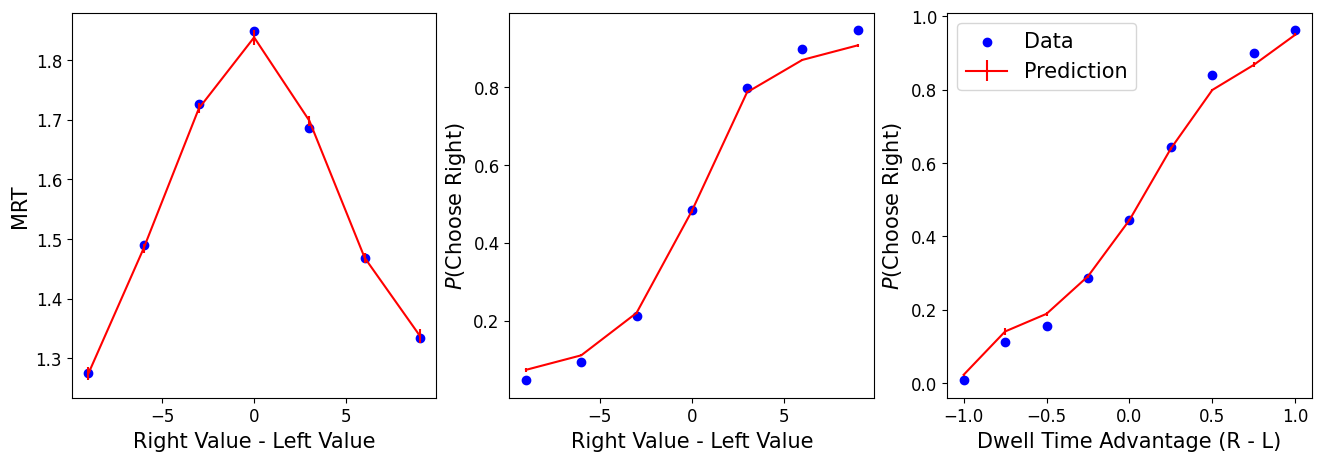

In [12]:
plt.figure(figsize=(16, 5))
plt.subplot(131)
se = pred_bhv.groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(pred_bhv.groupby(by='value_diff')['value_diff'].mean(),
             pred_bhv.groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red')
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(132)
se = pred_bhv.groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv.groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(133)
se = pred_bhv.groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(),
             y=pred_bhv.groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), 
            c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose Right)');
plt.legend();

plt.savefig('_plots/tv2017_complete_postpred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');

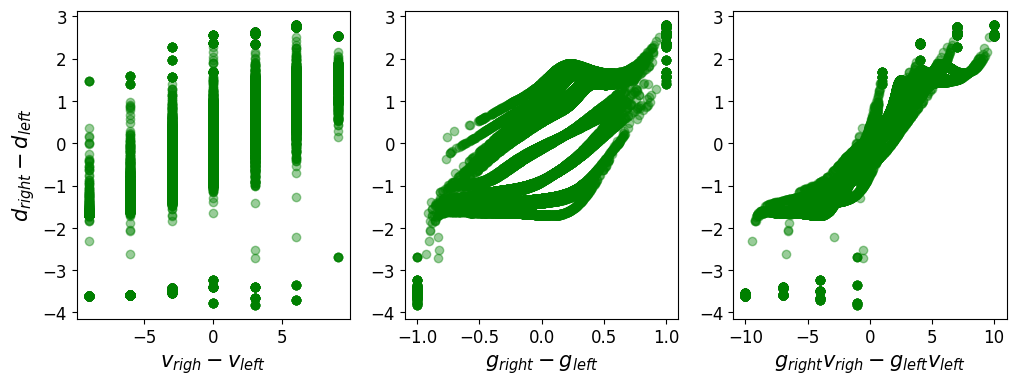

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 1] - X_test[:, 0], 
            pred_v[:, 1] - pred_v[:, 0], alpha=0.4, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');
plt.xlabel(r'$v_{righ} - v_{left}$ ');

plt.subplot(132)
plt.scatter(X_test[:, 3] - X_test[:, 2], 
            pred_v[:, 1] - pred_v[:, 0], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(133)
plt.scatter(X_test[:, 1]*X_test[:, 3] - X_test[:, 0]*X_test[:, 2], 
            pred_v[:, 1] - pred_v[:, 0], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/tv2017_complete_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');